# 任务总览
> **执行时画图可能会耗费一些时间**
- 数据预处理+单因素统计
    - 访问量
        - 分析随着时间公园总访问量的变化
    - 公园
        - 分析公园种类的数量分布
        - 画出公园在美国的位置分布
    - 人口
        - 分析人口的变化
    - 汽油
        - 分析汽油价格的变化
- 多因素分析
    - 公园
        > 贡献度：指定类型公园总访问量<br/>
        > 吸引度：指定类型公园每一所每年的平均访问量
        -  分析不同类型公园的贡献度和吸引度
        - 分析访问量最高的5种公园的访问量变化
    - 人口
        - 分析总人口变化与访问量的关系。
    - 汽油
        - 分析访问量变化和油价变化的关系。


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.style.use('ggplot')

In [2]:
parks = pd.read_csv("./data/All National Parks Visitation 1904-2016.csv")
gas = pd.read_csv("./data/gas_price.csv")
locations = pd.read_csv("./data/locations.csv")
pop = pd.read_csv("./data/state_pop.csv")

# 在后面分析中发现parks中有年份为Total的记录，应该在此处删除删除

# 数据预处理+单因素统计

## 分析随着时间公园总访问量的变化

In [3]:
print((parks["Visitors"].isnull()).sum())
print((parks["Visitors"] == 0).sum())
# 公园访问量为null的有4个
# 公园访问量为0的记录有180个。

4
180


In [4]:
parks[parks["Visitors"].isnull()]
# YearRaw为Total为Visitor值为NaN

,Created By,Measure Selector,Year,Date Edit,ScrapeURL,GIS Notes,Gnis Id,Geometry,Metadata,Number of Records,Parkname,Region,State,Unit Code,Unit Name,Unit Type,Visitors,YearRaw
300,Lands,1,1/1/2000 12:00:00 AM,8/13/2015,https://irma.nps.gov/Stats/SSRSReports/Park%20...,Lands - http://landsnet.nps.gov/tractsnet/docu...,2767391,POLYGON,http://nrdata.nps.gov/programs/Lands/HONO_meta...,1,Honouliuli,PW,HI,HONO,Honouliuli National Monument,National Monument,NaN,Total
308,Lands,1,1/1/2000 12:00:00 AM,10/15/2015,https://irma.nps.gov/Stats/SSRSReports/Park%20...,Lands - http://landsnet.nps.gov/tractsnet/docu...,2766708,MULTIPOLYGON,http://nrdata.nps.gov/programs/Lands/MIIN_meta...,1,Minidoka,PW,WA,MIIN,Minidoka National Historic Site,National Historic Site,NaN,Total
337,Lands,1,1/1/2000 12:00:00 AM,4/26/2016,https://irma.nps.gov/Stats/SSRSReports/Park%20...,Lands - http://landsnet.nps.gov/tractsnet/docu...,2035517,POLYGON,http://nrdata.nps.gov/programs/Lands/VALL_meta...,1,Valles Caldera,IM,NM,VALL,Valles Caldera National Preserve,Valles Caldera National Preserve,NaN,Total
369,Lands,1,1/1/2000 12:00:00 AM,9/12/2016,https://irma.nps.gov/Stats/SSRSReports/Park%20...,Lands - http://landsnet.nps.gov/tractsnet/docu...,2766905,POLYGON,http://nrdata.nps.gov/programs/Lands/PULL_meta...,1,Pullman,MW,IL,PULL,Pullman National Monument,National Monument,NaN,Total


In [5]:
# 应该是数据集本身有统计。此处不再会重新进行统计，所以删除YearRaw为Total的记录
parks = parks.drop(parks[parks["YearRaw"] == "Total"].index.values)

In [6]:
# 对于访问量为0的记录，因为不清楚原因，所以这里会画填补0值，以及不填0值的两张图

In [7]:
# 0值记录的年份
(parks[parks["Visitors"] == 0])['YearRaw'].unique()

array(['1941', '1991', '1990', '2016', '2015', '2014', '2013', '2012',
       '2010', '2007', '2005', '2003', '2004', '2001', '2000', '1999',
       '1997', '1995', '1996', '1994', '1993', '1947', '1988', '1946',
       '1945', '1944', '1943', '1942', '1982', '1981', '1980', '1965'],
      dtype=object)

In [8]:
# 0值记录的州
(parks[parks["Visitors"] == 0])['State'].unique()

array(['WA', 'MD', 'SC', 'NY', 'GA', 'MO', 'DC', 'ND', 'VA', 'MS', 'AK',
       'NJ', 'AS', 'MA', 'UT', 'CA', 'NM', 'NE', 'OH', 'FL', 'SD', 'OR',
       'MT'], dtype=object)

In [9]:
# 通过每年所有公园的访问量进行填补
v_mean = parks.loc[:, ["YearRaw", "Visitors"]].groupby("YearRaw").mean()
v_mean.head(3)

,Visitors
YearRaw,
1904,20115.000000
1905,23492.333333
1906,4367.000000


In [10]:
def set_mean(x, v_mean):
    x['Visitors'] = v_mean.loc[x['YearRaw']]
    return x['Visitors']


parks_n0 = (parks.loc[parks["Visitors"] == 0, ["Visitors", "YearRaw"]].apply(
    set_mean, args=(v_mean,), axis=1)).combine_first(parks)
# 使用combine_first 通过id覆盖parks中为0的

In [11]:
# 去完0
(parks_n0["Visitors"] == 0).sum()

0

In [12]:
# 以万为单位
p2 = (pd.concat([parks.loc[:, ["YearRaw"]], parks.loc[:, [
      "Visitors"]]/10000], axis=1)).groupby("YearRaw").sum()
p3 = (pd.concat([parks_n0.loc[:, ["YearRaw"]], parks_n0.loc[:, [
      "Visitors"]]/10000], axis=1)).groupby("YearRaw").sum()

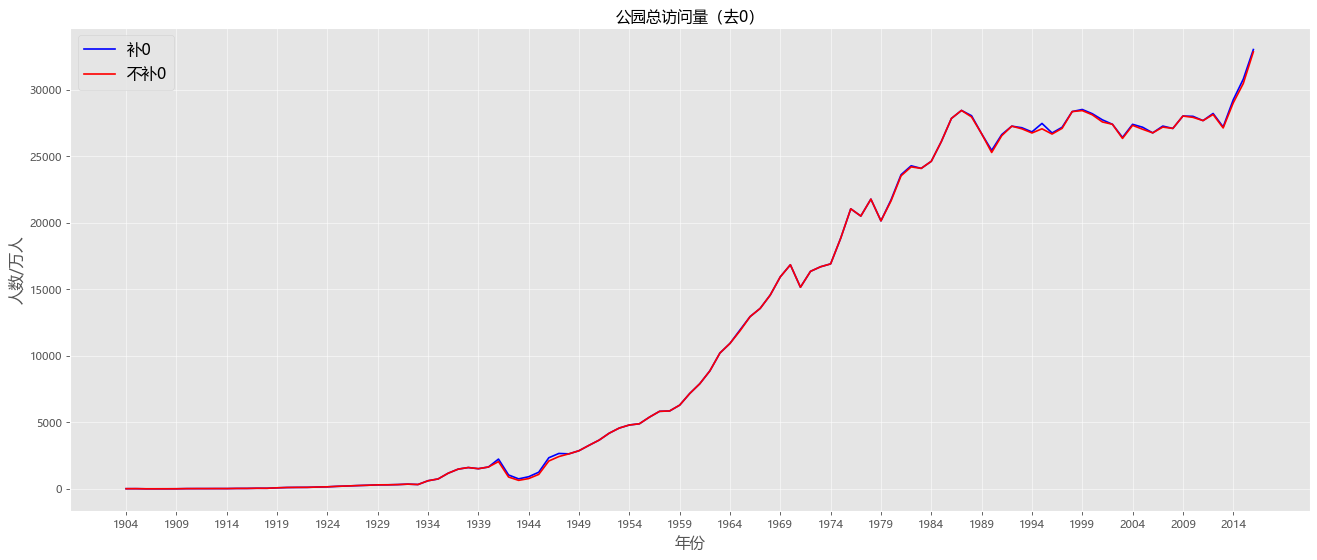

In [13]:
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
figure = plt.figure(num=1, figsize=(20, 8), dpi=80)
plt.plot(range(len(p3.index)), p3, "b-", label="补0")
plt.plot(range(len(p2.index)), p2, "r-", label="不补0")
plt.grid(alpha=0.6)
plt.legend(fontsize=14)
plt.xticks(range(len(p3.index))[::5], p3.index[::5])
plt.xlabel("年份", fontsize=14)
plt.ylabel("人数/万人", fontsize=14)
plt.title("公园总访问量（去0）", fontsize=14)
plt.show()

# 可以发现补0和不补会有非常小的区别，
# 但因为0值是缺失还是本身就是0无从考证
# 在下面的分析中会针对不同情况进行分析

## 分析公园种类的数量分布

In [14]:
parks.loc[:, ["Gnis Id", "Unit Type"]].isnull().sum()
# 不存在null

Gnis Id      0
Unit Type    0
dtype: int64

In [15]:
park_types = parks.loc[:, ["Gnis Id", "Unit Type"]
                       ].groupby("Unit Type").count()

In [16]:
park_types.head(3)

,Gnis Id
Unit Type,
Ecological and Historic Preserve,25
International Historic Site,4
National Battlefield,847


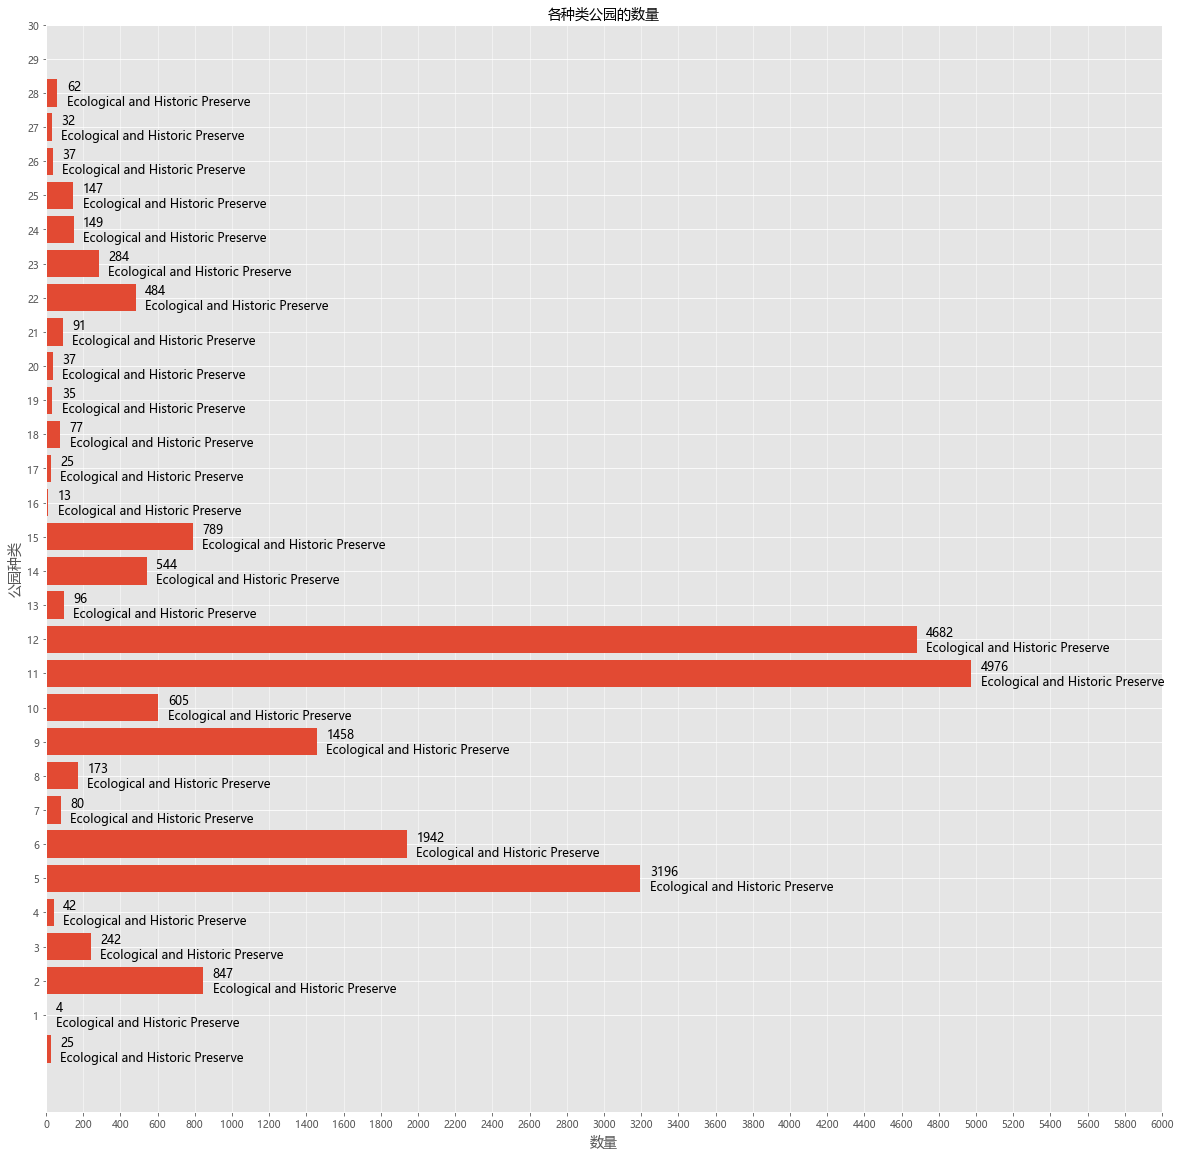

In [17]:
plt.figure(num=1, figsize=(20, 20))
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
x = range(len(park_types))
bar1 = plt.barh(x, park_types["Gnis Id"])
plt.grid(axis="x", alpha=0.6)
names = park_types.index
i = 0
# 标注总数量
for b in bar1:
    width = b.get_width()
    plt.text(width + 50, b.get_y() + b.get_height() / 2-0.44,
             str(width)+'\n'+names[i], ha='left', va='bottom', fontsize=12)
plt.xlim(0, 6000)
plt.xticks(range(0, 6000+1, 200))
plt.yticks(range(1, 31))
plt.xlabel("数量", fontsize=14)
plt.ylabel("公园种类", fontsize=14)
plt.title('各种类公园的数量', fontsize=14)
plt.show()

## 画出公园在美国的分布

In [18]:
# 用来画点的函数
def point_park(a, m, p):
    xpt, ypt = m(a[0], a[1])
    m.plot(xpt, ypt, p, markersize=3)

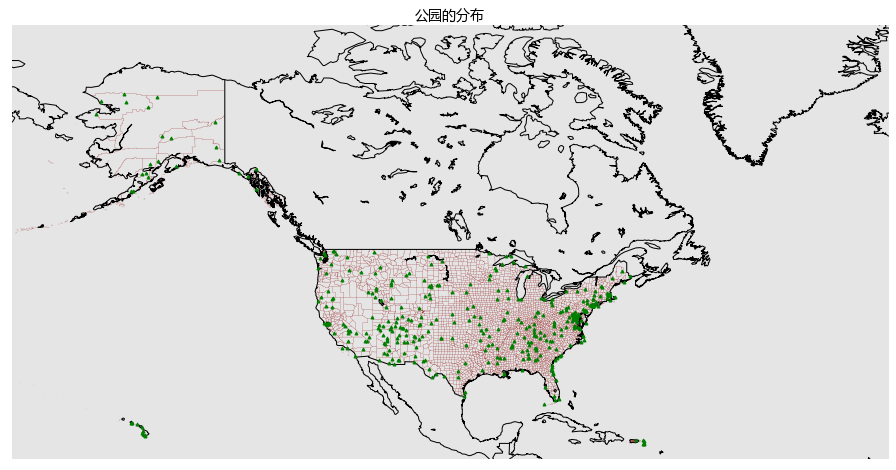

In [19]:
plt.figure(figsize=(20, 8))
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
m = Basemap(projection='mill',
            llcrnrlat=15,
            llcrnrlon=-180,
            urcrnrlat=75,
            urcrnrlon=-20,
            resolution='l')
# llcrnrlat - 左下角的纬度
# llcrnrlon - 左下角的经度
# urcrnrlat - 右上角的纬度
# urcrnrlon - 右上角的经度
# 此外，坐标需要转换，其中西经和南纬坐标是负值，北纬和东经坐标是正值。
m.drawcoastlines()
m.drawcountries(linewidth=1)
m.drawcounties(color='darkred')
# m.etopo()
locations.loc[:, ["lon", "lat"]].apply(point_park, axis=1, args=(m, 'g^'))
plt.title('公园的分布', fontsize=14)
plt.show()

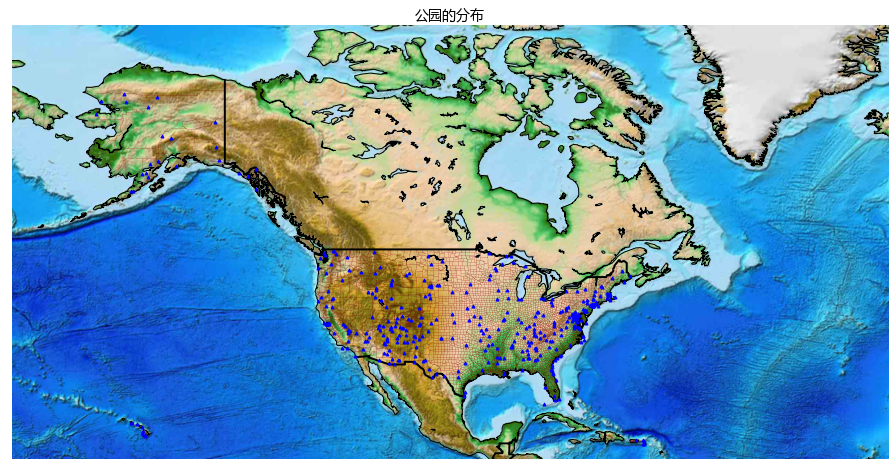

In [20]:
# 带上地形分布等等
plt.figure(figsize=(20, 8))
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
m = Basemap(projection='mill',
            llcrnrlat=15,
            llcrnrlon=-180,
            urcrnrlat=75,
            urcrnrlon=-20,
            resolution='l')
# llcrnrlat - 左下角的纬度
# llcrnrlon - 左下角的经度
# urcrnrlat - 右上角的纬度
# urcrnrlon - 右上角的经度
# 此外，坐标需要转换，其中西经和南纬坐标是负值，北纬和东经坐标是正值。
m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawcounties(color='darkred')
m.etopo(scale=0.5)  # 降低分辨率
locations.loc[:, ["lon", "lat"]].apply(point_park, axis=1, args=(m, 'b^'))
plt.title('公园的分布', fontsize=14)
plt.show()

## 分析人口的变化

In [21]:
pop.head()

,year,state,pop
0,1900,AL,1830000.0
1,1901,AL,1907000.0
2,1902,AL,1935000.0
3,1903,AL,1957000.0
4,1904,AL,1978000.0


In [22]:
# 一共有116年的数据
print(len(pop["year"].unique()))

116


In [23]:
# 50年
# 1900-1949年有的记录没有人口数据
print(len(pop["year"][pop["pop"].isnull()].unique()))
pop["year"][pop["pop"].isnull()].unique()

50


array([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949], dtype=int64)

In [24]:
print(pop["pop"].isnull().sum())  # 100条数据
print(pop["state"][pop["pop"].isnull()].unique())  # 一共俩州

100
['AK' 'HI']


In [25]:
# 一共100条记录没有数据
# 100条数据是50年间，两个州的
# 预计两个州个各50年的人口没有统计，进行验证
print((pop["pop"][pop["state"] == 'AK']).isnull().sum())
print((pop["pop"][pop["state"] == 'HI']).isnull().sum())
# 正确

50
50


In [26]:
# 使用每年的其他州平均数据进行填补
for i in range(1900, 1950):
    pop.loc[(pop["state"] == 'AK') & (pop['year'] == i),
            'pop'] = (pop['pop'][pop['year'] == i]).mean()
    pop.loc[(pop["state"] == 'HI') & (pop['year'] == i),
            'pop'] = (pop['pop'][pop['year'] == i]).mean()

In [27]:
pop.isnull().sum()

year     0
state    0
pop      0
dtype: int64

In [28]:
# 在此处为了降低缺失值的影响，可以通过其他州平均人数进行填充
# 而目的为统计人口变化
# 所以可以变换为统计所有州平均人数变化
p1 = pop.dropna(axis=0).groupby("year").aggregate({
    "state": len,
    "pop": np.sum
})
p_avg = p1["pop"]/p1["state"]
p_avg.head(3)

year
1900    1.552959e+06
1901    1.583429e+06
1902    1.615510e+06
dtype: float64

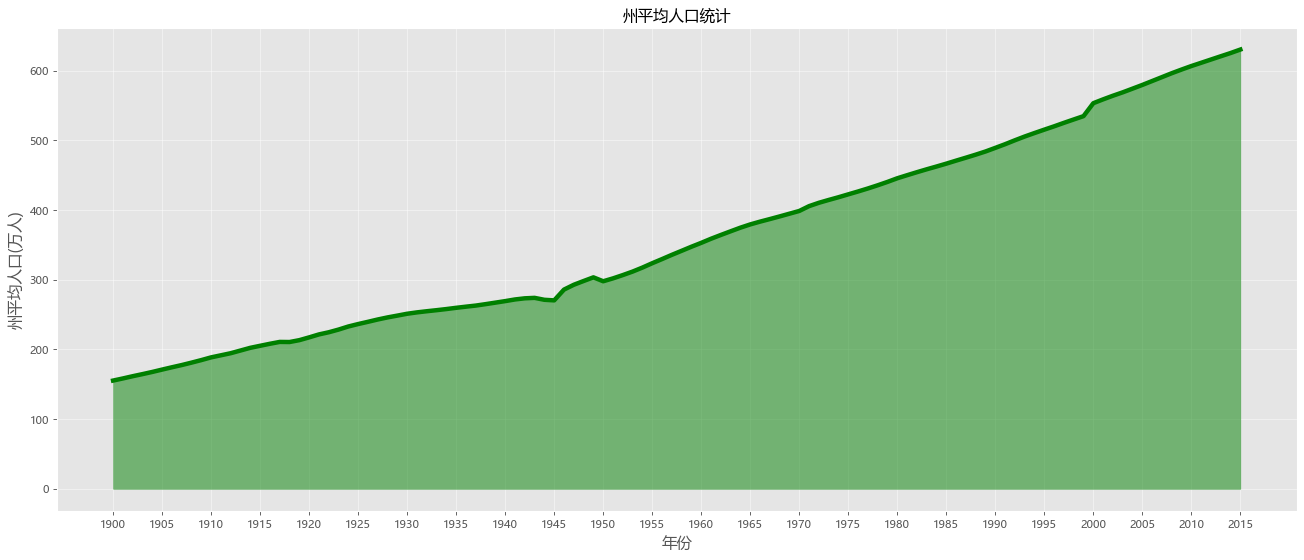

In [29]:
plt.figure(num=1, figsize=(20, 8), dpi=80)
plt.grid(alpha=0.5)
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.xlabel("年份", fontsize=14)
plt.ylabel("州平均人口(万人)", fontsize=14)
plt.plot(p_avg.index, (p_avg/10000).astype("float"), 'g-', linewidth=4)
plt.title("州平均人口统计", fontsize=14)
plt.fill_between(p_avg.index, 0, (p_avg/10000).astype("float"),
                 color='green', alpha=0.5)
plt.xticks(range(np.min(p_avg.index), np.max(
    p_avg.index)+1, 5), p_avg.index[::5])
plt.show()

## 分析汽油价格的变化

In [30]:
gas.info()
# 没有缺失数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          87 non-null     int64  
 1   gas_current   87 non-null     float64
 2   gas_constant  87 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.2 KB


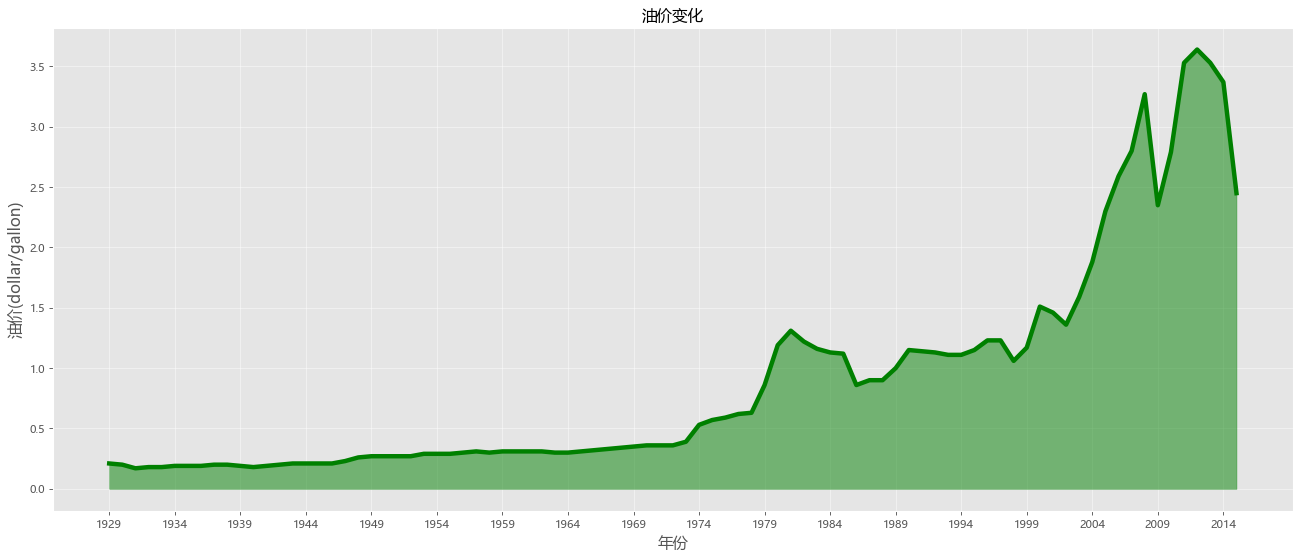

In [31]:
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(num=1, figsize=(20, 8), dpi=80)
plt.grid(alpha=0.5)
plt.plot(range(len(gas)), gas["gas_current"], 'g-', linewidth=4)
plt.xticks(range(len(gas))[::5], gas["year"][::5])
plt.xlabel("年份", fontsize=14)
plt.ylabel("油价(dollar/gallon)", fontsize=14)
plt.title('油价变化', fontsize=14)
plt.fill_between(range(len(gas)), 0,
                 gas["gas_current"], color='green', alpha=0.5)
plt.show()

# 多因素分析

## 不同类型公园的贡献度和吸引度

In [32]:
# 因为数量相差很大，所以应该使用每个种类的平均访问量
# 因为如果一个访问量为0会严重影响平均，不管是数据错误还是公园闭馆等情况都不能使用为0的记录
# 所以这里不会考虑为0的记录

def wan_sum(x):  # 以万为单位
    return np.sum(x)/10000


parks_d0 = parks[parks['Visitors'] != 0]
park_v_t = parks_d0.loc[:, ["Visitors", "Unit Type", "Gnis Id"]].groupby(
    "Unit Type").aggregate({'Visitors': wan_sum, 'Gnis Id': len})

In [33]:
park_v_t.head(3)

,Visitors,Gnis Id
Unit Type,,
Ecological and Historic Preserve,1801.8607,25
International Historic Site,4.8711,4
National Battlefield,15028.7669,836


In [34]:
park_v_t_avg = np.round(park_v_t['Visitors']/park_v_t['Gnis Id'], 3)

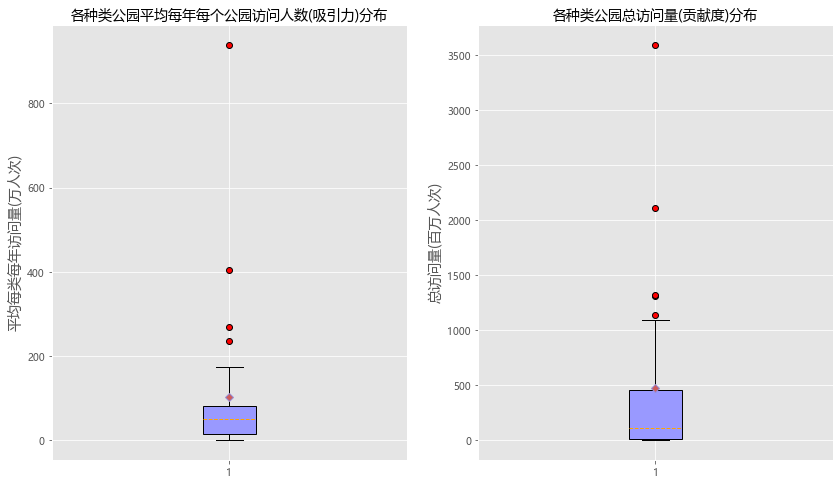

In [35]:
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.boxplot(x=park_v_t_avg,
            patch_artist=True,
            showmeans=True,
            boxprops={'color': 'black', 'facecolor': '#9999ff'},
            flierprops={'marker': 'o',
                        'markerfacecolor': 'red', 'color': 'black'},
            meanprops={'marker': 'D', 'markerfacecolor': 'indianred'},
            medianprops={'linestyle': '--', 'color': 'orange'})
plt.ylabel("平均每类每年访问量(万人次)", fontsize=14)
plt.title('各种类公园平均每年每个公园访问人数(吸引力)分布', fontsize=14)
plt.subplot(122)
plt.boxplot(x=park_v_t['Visitors']/100,
            patch_artist=True,
            showmeans=True,
            boxprops={'color': 'black', 'facecolor': '#9999ff'},
            flierprops={'marker': 'o',
                        'markerfacecolor': 'red', 'color': 'black'},
            meanprops={'marker': 'D', 'markerfacecolor': 'indianred'},
            medianprops={'linestyle': '--', 'color': 'orange'})
plt.ylabel("总访问量(百万人次)", fontsize=14)
plt.title('各种类公园总访问量(贡献度)分布', fontsize=14)
plt.show()

In [36]:
park_v_t_avg.min(), park_v_t['Visitors'].min()

(0.245, 4.8711)

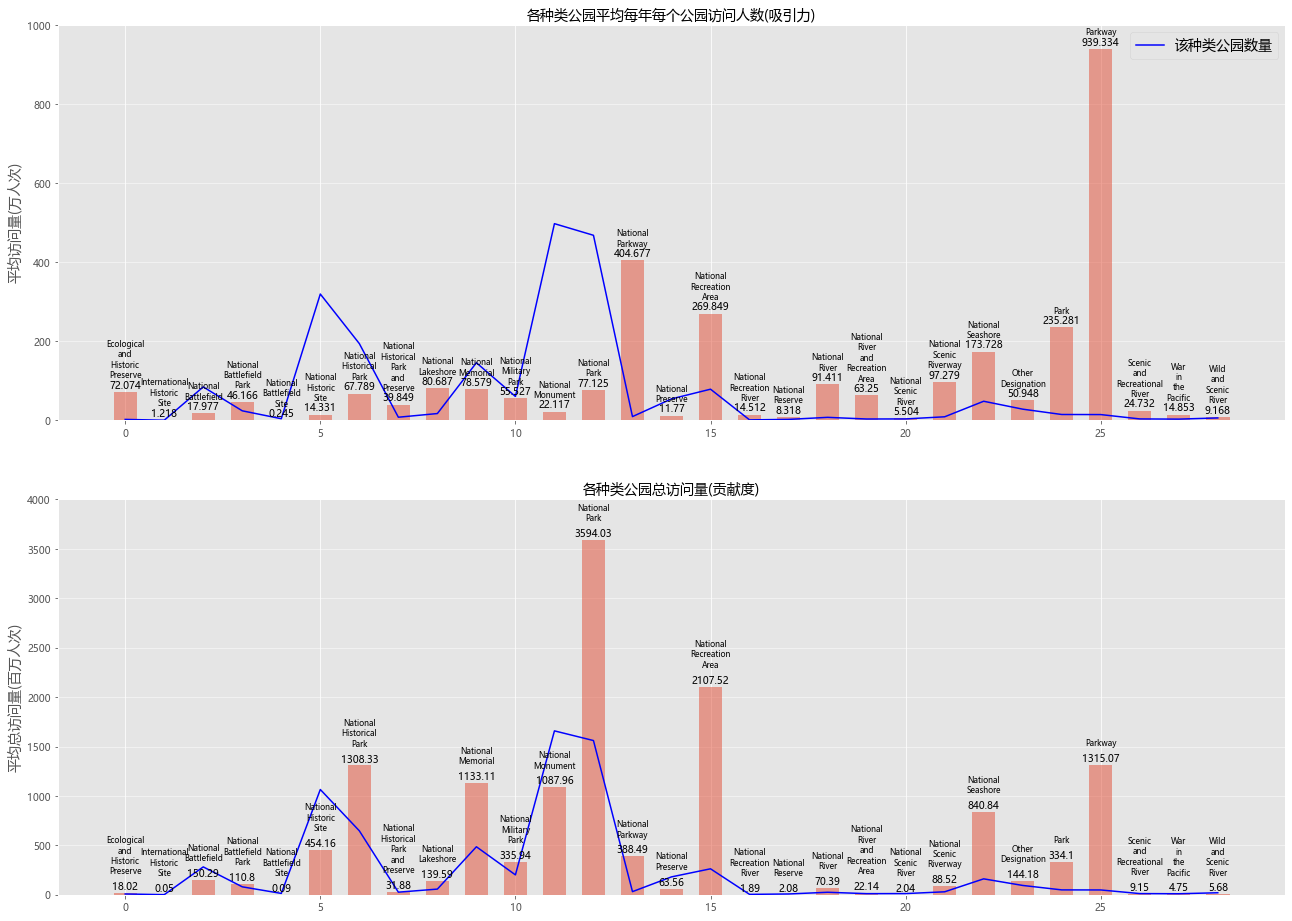

In [37]:
plt.figure(num=1, figsize=(22, 16))
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

plt.subplot(211)
x = range(len(park_v_t_avg))
bar1 = plt.bar(x, park_v_t_avg, width=0.6,alpha = 0.5)
plt.plot(x, park_types["Gnis Id"]/10,label='该种类公园数量比较',c='b')
plt.grid(axis="y", alpha=0.6)
names = park_v_t_avg.index.str.replace(" ", "\n")
i = 0
# 标注总数量
for b in bar1:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width() / 2, height + 1,
             str(height), ha='center', va='bottom')
# 标注种类名称
for b in bar1:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width() / 2, height + 30,
             names[i], ha='center', va='bottom', fontsize=8)
    i += 1
plt.legend(['该种类公园数量'],fontsize=14)
plt.ylim(0, 1000)
plt.ylabel("平均访问量(万人次)", fontsize=14)
plt.title('各种类公园平均每年每个公园访问人数(吸引力)', fontsize=14)


# 总访问量
plt.subplot(212)
x = range(len(park_v_t))
bar1 = plt.bar(x, np.round(park_v_t['Visitors']/100, 2), width=0.6,alpha=0.5)  # 调整为百万
plt.plot(x, park_types["Gnis Id"]/3,label='该种类公园数量比较',c='b')
plt.grid(axis="y", alpha=0.6)
names = park_v_t.index.str.replace(" ", "\n")
i = 0
# 标注总数量
for b in bar1:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width() / 2, height + 1,
             str(height), ha='center', va='bottom')
# 标注种类名称
for b in bar1:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width() / 2, height + 170,
             names[i], ha='center', va='bottom', fontsize=8)
    i += 1
plt.ylim(0, 4000)
plt.ylabel("平均总访问量(百万人次)", fontsize=14)
plt.title('各种类公园总访问量(贡献度)', fontsize=14)

plt.show()

## 分析访问量最高的5种公园访问量变化

In [38]:
most_popular_5 = park_v_t.sort_values(
    ascending=False, by='Visitors')[0:5].index

In [39]:
most_popular_5

Index(['National Park', 'National Recreation Area', 'Parkway',
       'National Historical Park', 'National Memorial'],
      dtype='object', name='Unit Type')

In [40]:
# 得到每一个公园类型每年的访问量
parks_type_var = parks[['Visitors', 'YearRaw', 'Unit Type']].pivot_table(
    'Visitors', index='YearRaw', columns='Unit Type', aggfunc=wan_sum)  # 这里依旧使用万人次进行统计
parks_type_var = parks_type_var.round(2)
parks_type_var.tail(3)

Unit Type,Ecological and Historic Preserve,International Historic Site,National Battlefield,National Battlefield Park,National Battlefield Site,National Historic Site,National Historical Park,National Historical Park and Preserve,National Lakeshore,National Memorial,...,National River and Recreation Area,National Scenic River,National Scenic Riverway,National Seashore,Other Designation,Park,Parkway,Scenic and Recreational River,War in the Pacific,Wild and Scenic River
YearRaw,,,,,,,,,,,,,,,,,,,,,
2014,112.13,1.16,224.89,286.80,NaN,997.97,2960.43,44.55,376.67,3283.10,...,68.55,9.19,196.80,1854.67,466.49,275.30,1978.82,23.08,26.62,21.61
2015,123.94,1.26,226.46,297.02,NaN,1002.80,2961.60,40.56,413.17,3701.22,...,77.08,10.48,190.11,1870.62,490.74,275.59,2084.04,24.32,32.25,21.46
2016,114.85,1.39,247.15,330.64,NaN,1107.76,3193.09,43.84,434.30,3799.80,...,94.17,10.80,194.97,1979.72,529.28,282.32,2106.69,26.44,48.90,23.19


In [41]:
parks_type_var.isnull().sum()
# 因为公园可能建立时间较晚，或者废弃时间较早，所以会有很多公园在一定时间段内没有访问数据
# 该部分不需要处理。在画图时跳过即可

Unit Type
Ecological and Historic Preserve          88
International Historic Site              109
National Battlefield                      30
National Battlefield Park                 30
National Battlefield Site                 71
National Historic Site                    32
National Historical Park                  16
National Historical Park and Preserve     33
National Lakeshore                        69
National Memorial                         30
National Military Park                    30
National Monument                          7
National Park                              0
National Parkway                          62
National Preserve                         27
National Recreation Area                  33
National Recreation River                100
National Reserve                          88
National River                            69
National River and Recreation Area        84
National Scenic River                     89
National Scenic Riverway                  66


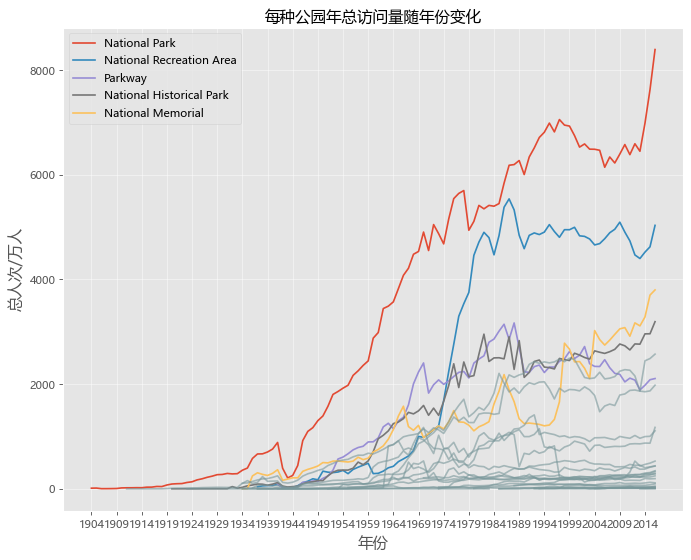

In [42]:
min_year = int(parks_type_var.index.min())
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(num=1, figsize=(10, 8), dpi=80)

for i in most_popular_5:
    temp = parks_type_var[i][parks_type_var[i].notnull()]
    # print(temp.index.min(),temp.index.max())
    # print(len(temp))
    plt.plot(temp.index.astype('int')-min_year, temp, label=i)
for i in parks_type_var.columns:
    if i not in most_popular_5:
        temp = parks_type_var[i][parks_type_var[i].notnull()]
        plt.plot(temp.index.astype('int')-min_year,
                 temp, label=i, c='#79979A', alpha=0.6)


plt.grid(alpha=0.5)
plt.xticks(range(len(parks_type_var.index))[::5], parks_type_var.index[::5])
plt.xlabel('年份', fontsize=14)
plt.ylabel('总人次/万人', fontsize=14)
plt.legend(most_popular_5)
plt.title('每种公园年总访问量随年份变化', fontsize=14)
plt.show()

## 分析人口变化与问量的关系。

In [43]:
len(pop['state'].unique())
#  一共有51个州，不可能每个州都分析一遍，所以这里比较总人口的变化与总访问量的变化
# 因为是总访问人次，所以此处不会处理0值

51

In [44]:
parks_v_p = parks[['YearRaw', 'Visitors']].groupby('YearRaw').sum()
parks_v_p.head(3)

,Visitors
YearRaw,
1904,120690.0
1905,140954.0
1906,30569.0


In [45]:
pop_a = pop[['year', 'pop']].groupby('year').sum()
pop_a.head(3)

,pop
year,
1900,7.920092e+07
1901,8.075486e+07
1902,8.239102e+07


In [46]:
parks_v_p.index.min(), parks_v_p.index.max()

('1904', '2016')

In [47]:
pop_a.index.min(), pop_a.index.max()

(1900, 2015)

In [48]:
# 索引转换为int
parks_v_p['Visitors'].index = parks_v_p['Visitors'].index.astype('int')

In [49]:
# 取出交集范围
parks_v_p_1 = parks_v_p['Visitors'].loc[str(
    parks_v_p.index.min()):str(pop_a.index.max())]
pop_a_1 = pop_a['pop'].loc[str(parks_v_p.index.min()):str(pop_a.index.max())]

In [50]:
parks_v_p_1.head()

YearRaw
1904    120690.0
1905    140954.0
1906     30569.0
1907     32935.0
1908     42768.0
Name: Visitors, dtype: float64

In [51]:
pop_a_1.head()

year
1904    8.551867e+07
1905    8.723914e+07
1906    8.892631e+07
1907    9.055206e+07
1908    9.232665e+07
Name: pop, dtype: float64

In [52]:
# 计算人均访问量
per = parks_v_p_1/pop_a_1

In [53]:
# 为了比较趋势，这里进行归一化
v_max = parks_v_p['Visitors'].max()
v_min = parks_v_p['Visitors'].min()
parks_v_p = (parks_v_p['Visitors']-v_min)/(v_max-v_min)

p_max = pop['pop'].max()
p_min = pop['pop'].min()
pop_a = (pop_a['pop']-p_min)/(v_max-v_min)

per_max = per.max()
per_min = per.min()
per = (per-per_min)/(per_max-per_min)

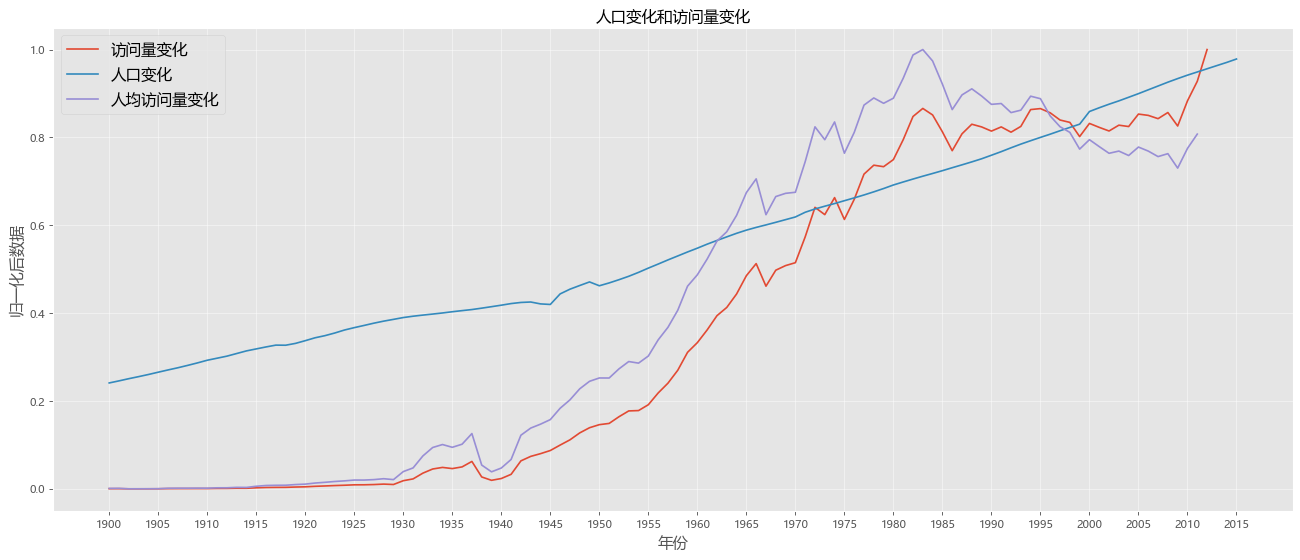

In [54]:
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(num=1, figsize=(20, 8), dpi=80)
plt.grid(alpha=0.5)
plt.plot(range(len(parks_v_p)), parks_v_p, label='访问量变化')
plt.plot(range(len(pop_a)), pop_a, label='人口变化')
plt.plot(range(len(per)), per, label='人均访问量变化')
plt.xticks(range(len(pop_a))[::5], pop_a.index[::5])
plt.xlabel('年份', fontsize=14)
plt.ylabel('归一化后数据', fontsize=14)
plt.legend(fontsize=14)
plt.title('人口变化和访问量变化', fontsize=14)
plt.show()

## 分析访问量变化和油价变化的关系。

In [55]:
# 最早只有1929年的
gas['year'].min(), gas['year'].max()

(1929, 2015)

In [56]:
# 截取1929-2015的人均访问人次变化
per_x=per.loc['1929':'2015']
per_x.head(1)

YearRaw
1929    0.019955
dtype: float64

In [57]:
# gas的归一化
g_max = gas['gas_current'].max()
g_min = gas['gas_current'].min()
gas_g = (gas['gas_current']-g_min)/(g_max-g_min)

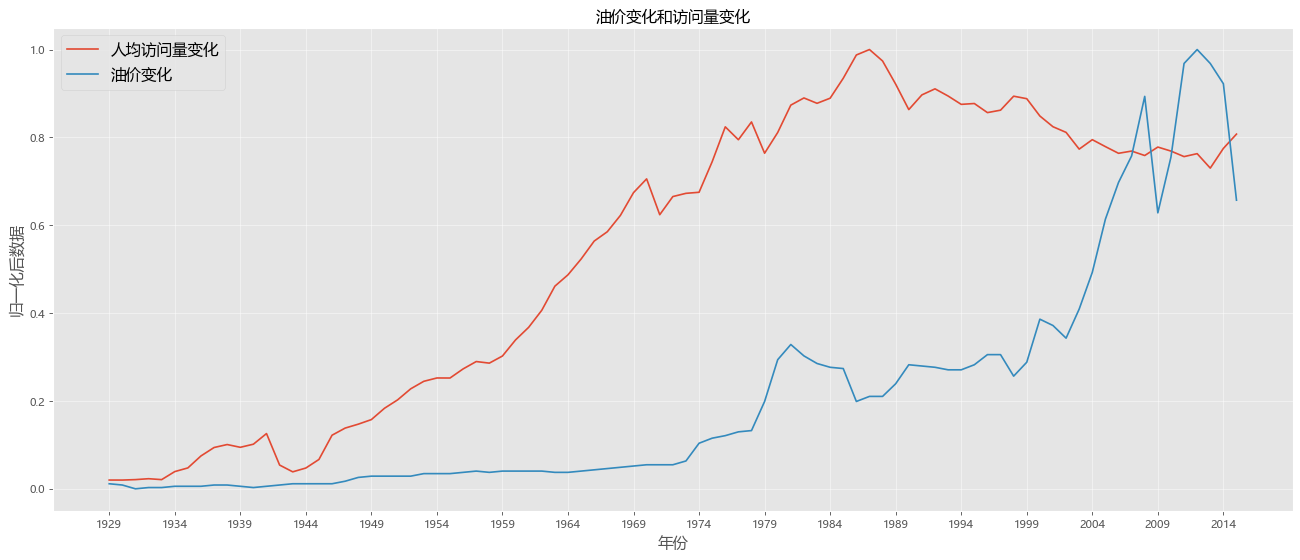

In [58]:
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(num=1, figsize=(20, 8), dpi=80)
plt.grid(alpha=0.5)
plt.plot(range(len(per_x)),per_x, label='人均访问量变化')
plt.plot(range(len(gas_g)), gas_g, label='油价变化')
plt.xticks(range(len(per_x.index))[::5],per_x.index[::5])
plt.xlabel('年份', fontsize=14)
plt.ylabel('归一化后数据', fontsize=14)
plt.legend(fontsize=14)
plt.title('油价变化和访问量变化', fontsize=14)
plt.show()